In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import pandas as pd
import os
import sys
sys.path.append('/home/hy381/model_training/src')
import utils


2025-02-07 12:44:24.874134: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 12:44:24.908842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
os.chdir('/home/hy381/rds/hpc-work/segmented_data_new')
data_labels = pd.read_csv('segmented_data_combined_apnea.csv')

Visualizing Mel Spectrograms

In [6]:
num_mel_bins = 64
sampling_rate = 8000
sequence_stride = 160
fft_length = 1000
n_samples = 320000

In [9]:
non_apnea_files = data_labels[data_labels['label'] == 0]['file'].values.astype(str)
hypopnea_files = data_labels[data_labels['label'] == 1]['file'].values.astype(str)
apnea_files = data_labels[data_labels['label'] == 2]['file'].values.astype(str)

In [12]:
non_apnea_dataset = tf.data.TFRecordDataset(non_apnea_files)
hypopnea_dataset = tf.data.TFRecordDataset(hypopnea_files)
apnea_dataset = tf.data.TFRecordDataset(apnea_files)

In [22]:
mel_spec_layer = tf.keras.layers.MelSpectrogram(num_mel_bins = num_mel_bins, sampling_rate = sampling_rate, sequence_stride = sequence_stride, fft_length = fft_length, min_freq = 70, max_freq = 3000, power_to_db=True)

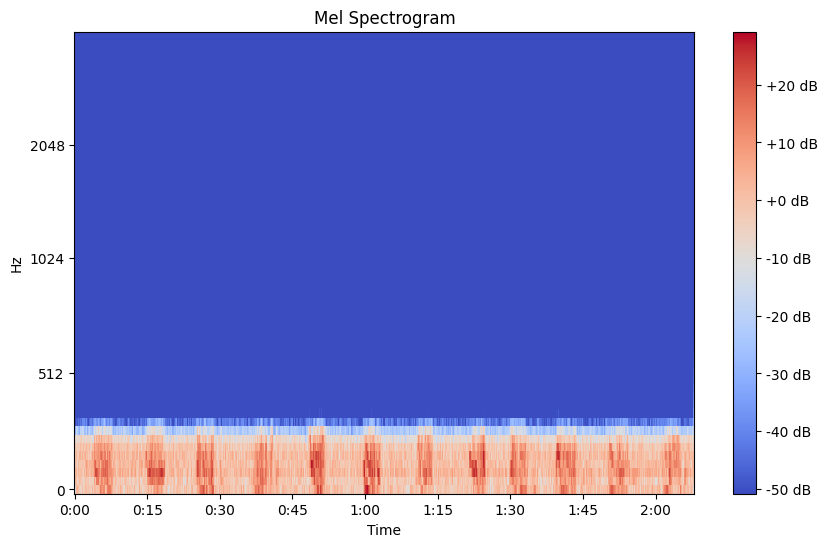

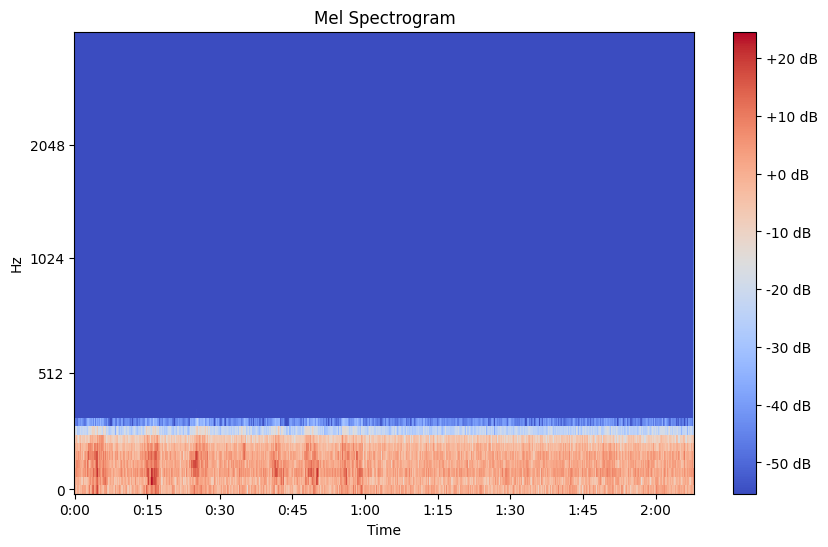

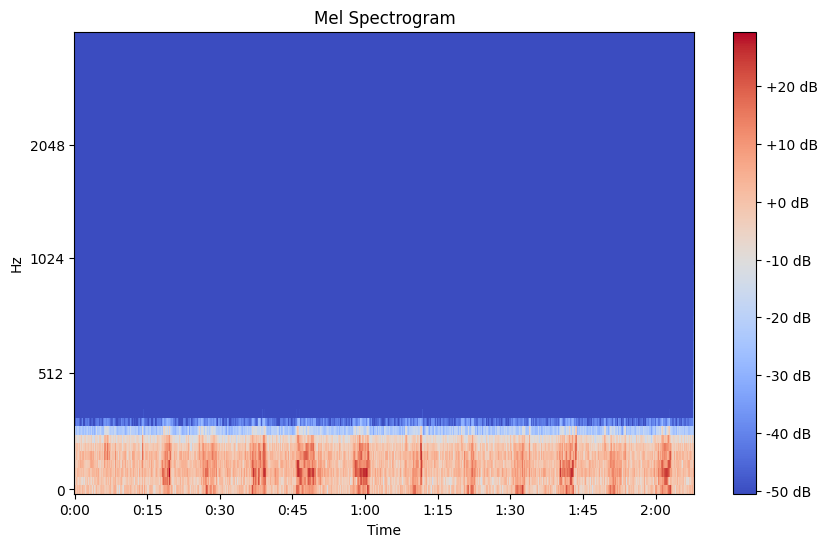

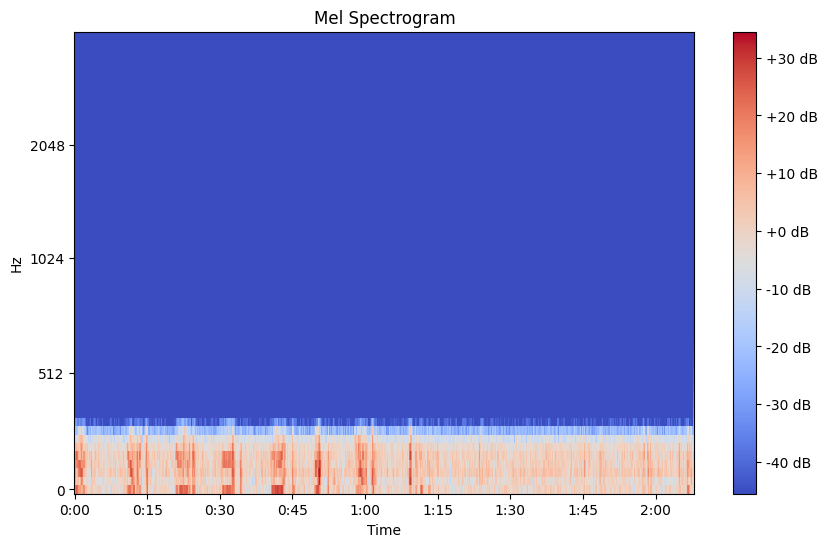

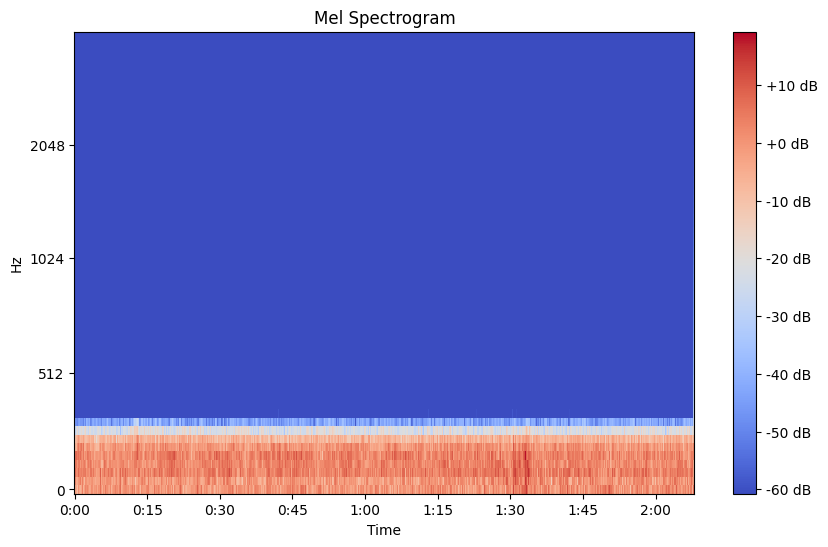

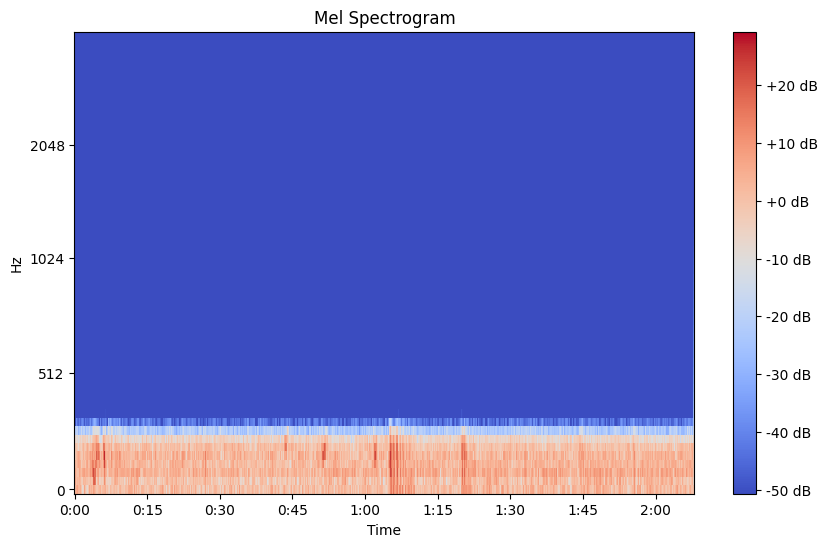

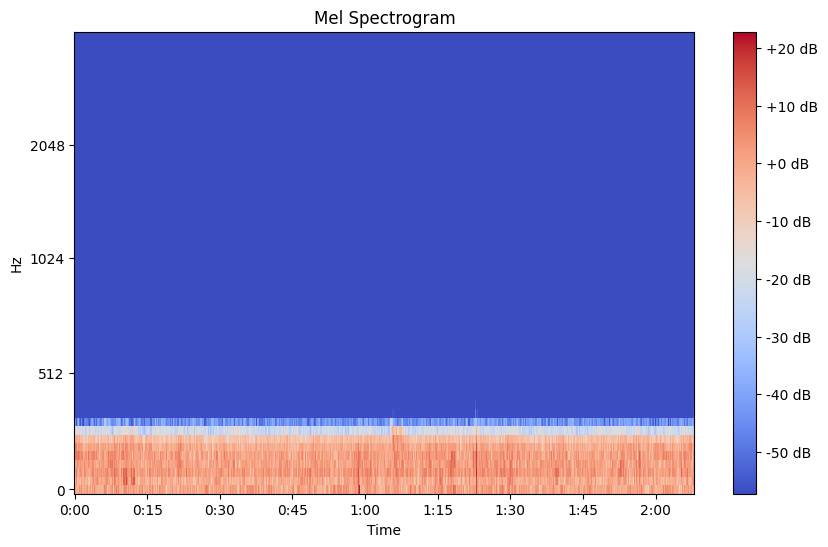

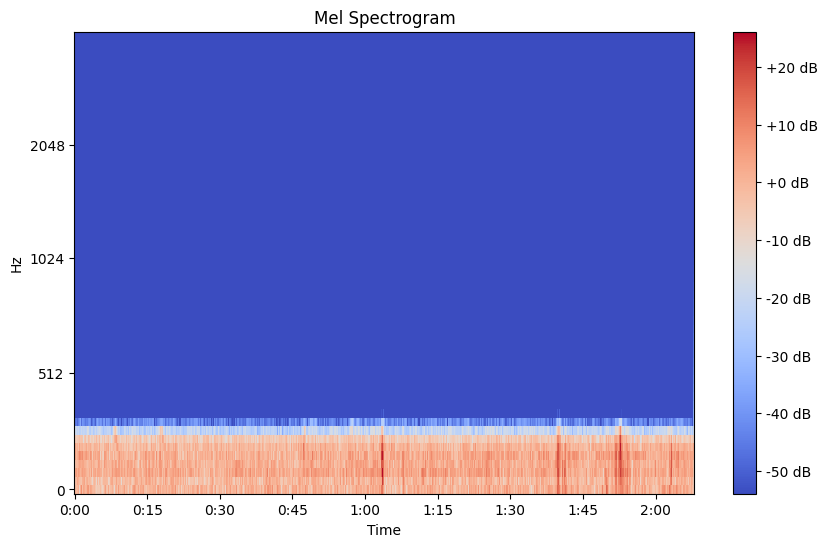

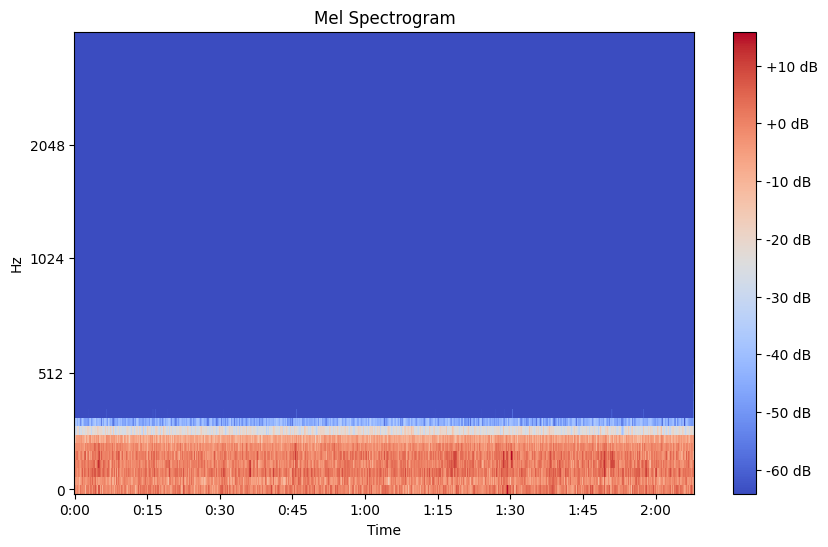

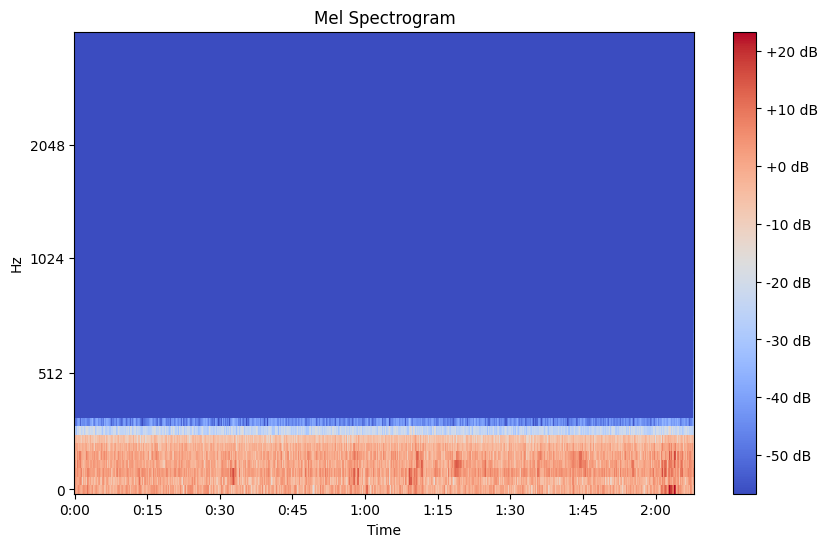

In [25]:
for data in apnea_dataset.take(10): 
    audio, _ , _ = utils._parse_data(data, ['audio'])
    mel_spec = mel_spec_layer(audio)
    mel_spec = mel_spec.numpy()
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spec, x_axis = 'time', y_axis='mel', sr=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

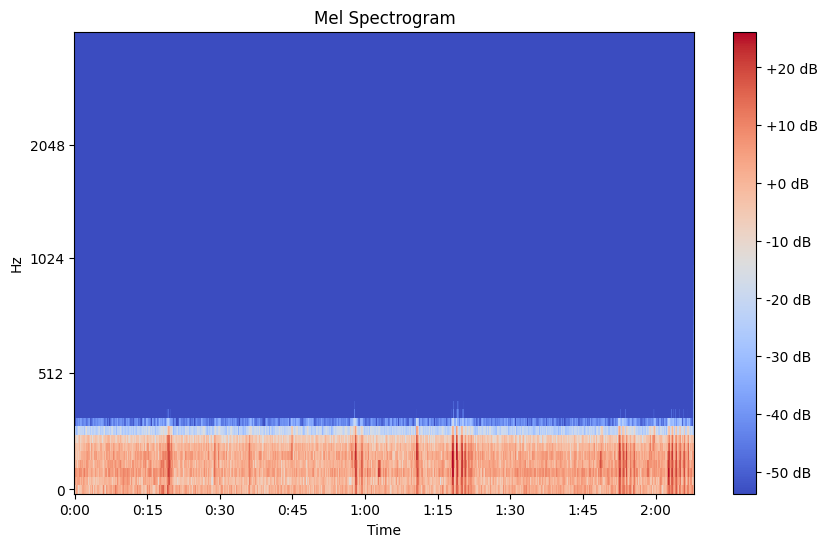

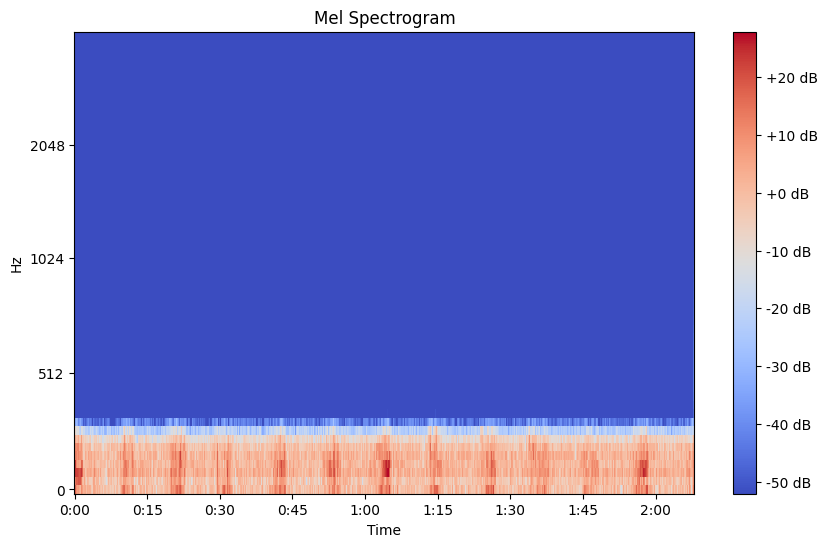

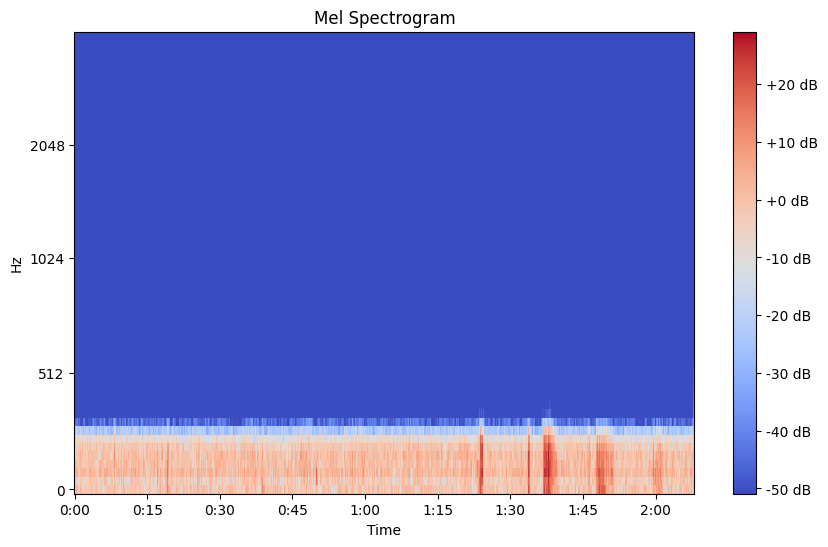

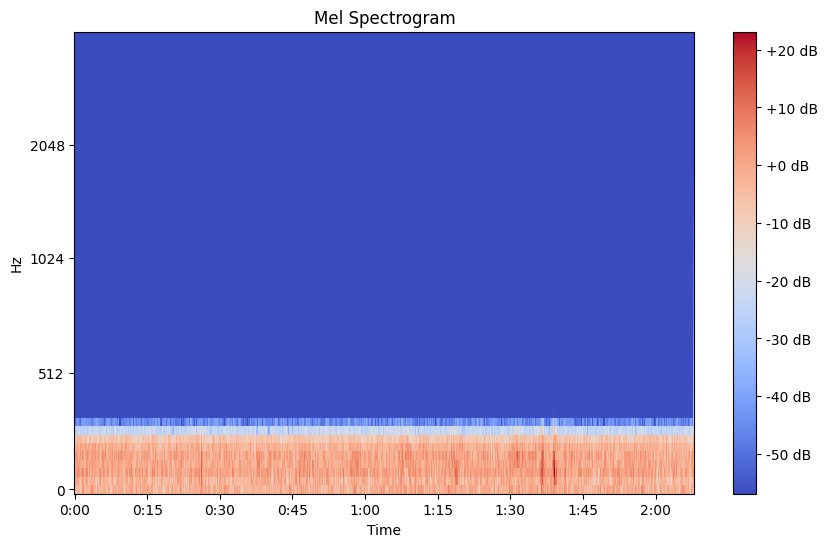

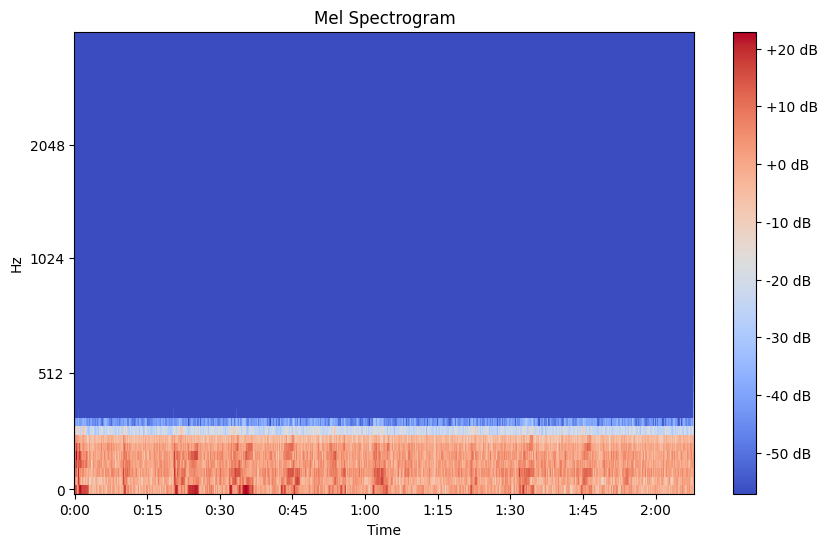

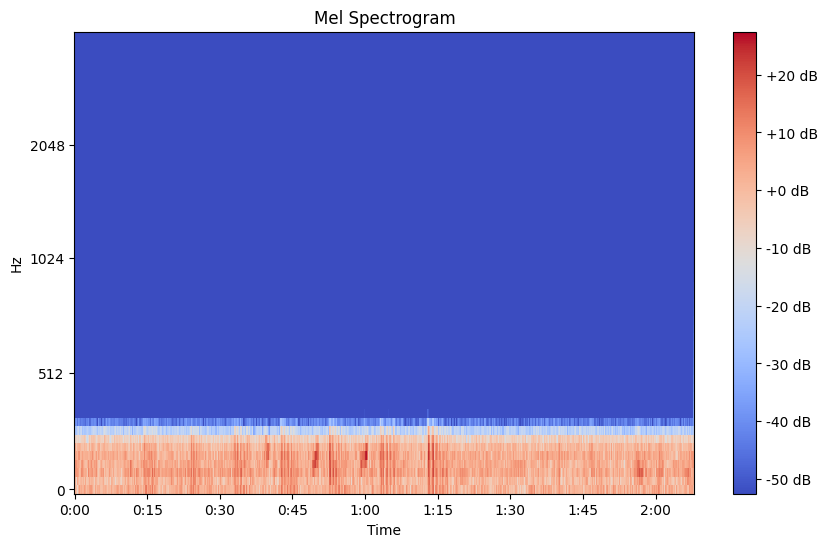

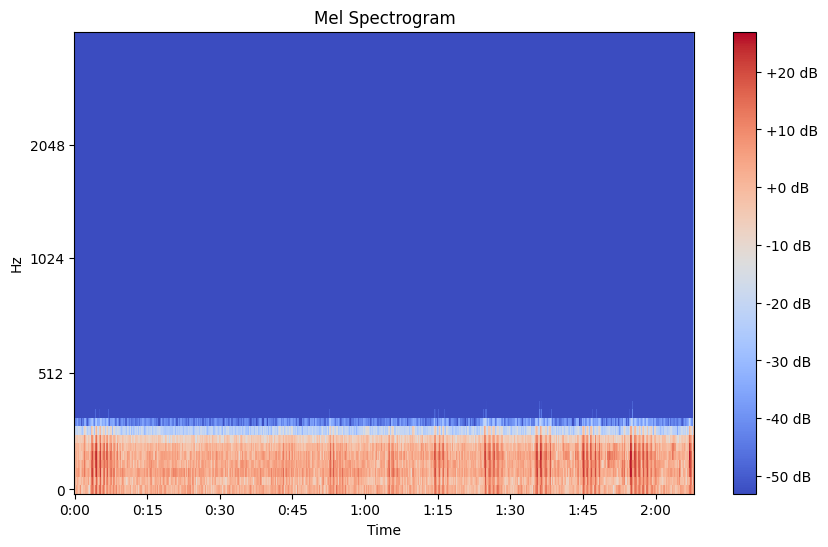

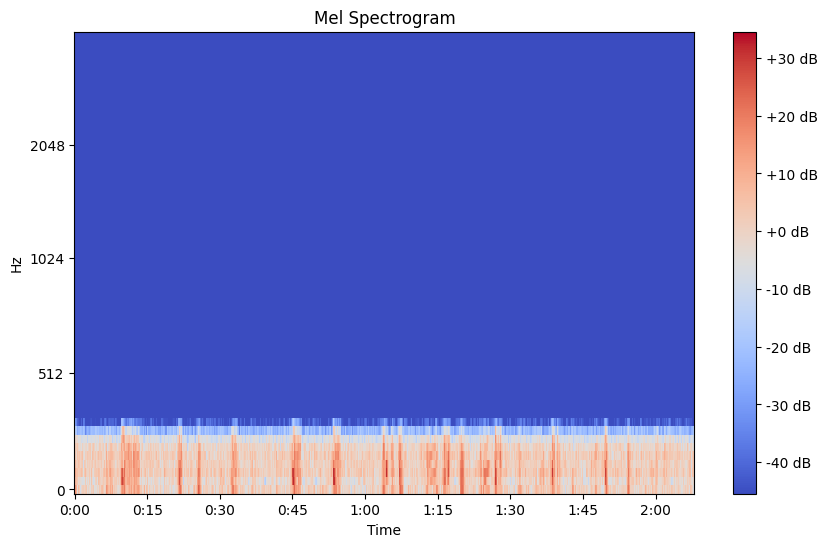

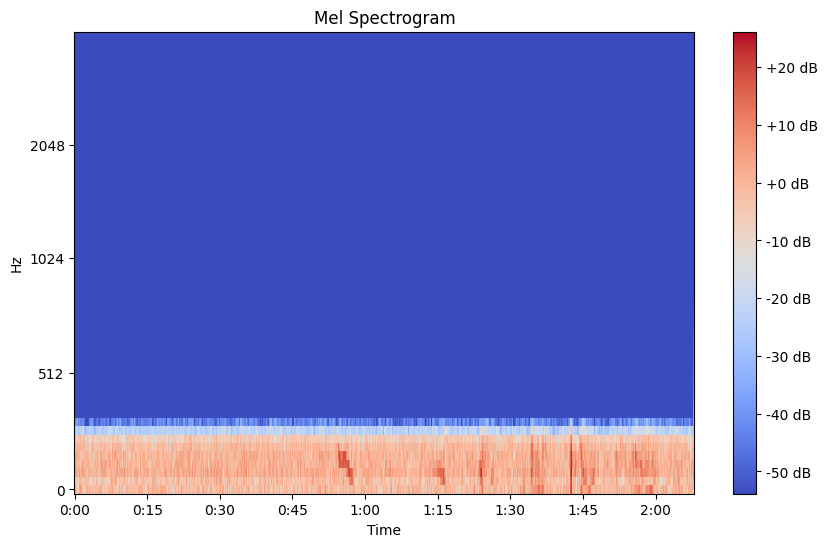

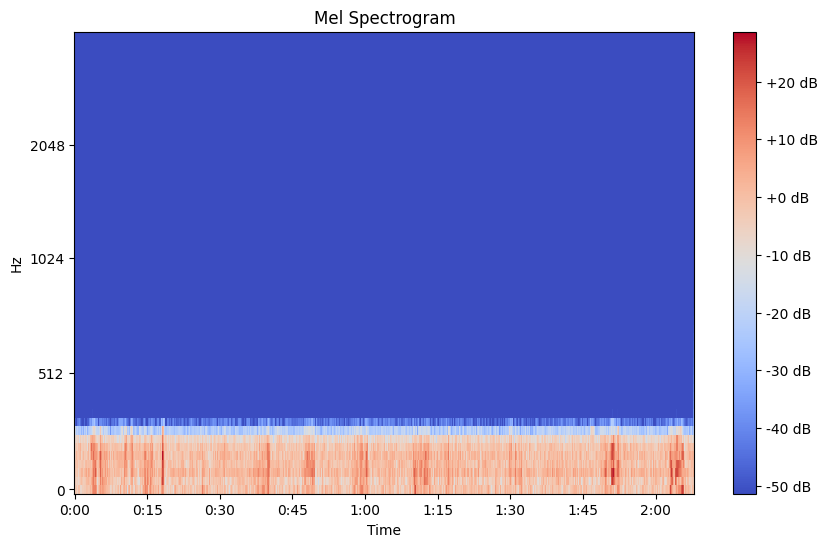

2025-02-07 12:53:13.062445: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
for data in non_apnea_dataset.take(10): 
    audio, _ , _ = utils._parse_data(data, ['audio'])
    mel_spec = mel_spec_layer(audio)
    mel_spec = mel_spec.numpy()
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spec, x_axis = 'time', y_axis='mel', sr=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

In [8]:
train_files, valid_files, test_files = utils.split_train_valid_test(data_labels, 0.7, 0.15)

In [9]:
sample_data = tf.data.TFRecordDataset(train_files)
parsed_data = utils.parse_tf_record_dataset(sample_data, ['audio'], use_delta = False, normalize = False)

In [11]:
def standardize(x): 
    # x_tensor = tf.convert_to_tensor(x, dtype = tf.float32)
    mean = tf.reduce_mean(x)
    std = tf.math.reduce_std(x)
    return (x - mean)/std

In [14]:
model = tf.keras.models.Sequential()
# Input Layer - all inputs are dimensions (320,000, ) -> outputs (320,000, ) 
model.add(tf.keras.layers.InputLayer(input_shape = (320000,), dtype = 'float32'))
# Convert audio to mel spectrogram -> outputs (num_mel_bins = 80, 2501)
model.add(tf.keras.layers.MelSpectrogram(num_mel_bins = num_mel_bins, sampling_rate = sampling_rate, sequence_stride = sequence_stride, fft_length = fft_length, min_freq = 70, max_freq = 7500, power_to_db=True))

for data in parsed_data.take(1):
    audio = data[0].numpy()
    audio = np.expand_dims(audio, axis = 0)
    output = model(audio)
    print(output)

model.add(tf.keras.layers.Lambda(lambda x : standardize(x)))
# model.add(tf.keras.layers.Normalization())

for data in parsed_data.take(1):
    audio = data[0].numpy()
    audio = np.expand_dims(audio, axis = 0)
    output = model(audio)
    print(output)

tf.Tensor(
[[[ -2.9857838   -1.6252027    0.20867236 ...  -3.6509094    1.9665627
     3.9285598 ]
  [  0.8370129    1.8962264    2.0645697  ...  -2.057226     0.8795073
     1.9138759 ]
  [ -0.38989332  -1.1522402   -2.0288959  ...  -3.6715043   -3.766469
    -4.704802  ]
  ...
  [-61.03132    -61.03132    -61.03132    ... -61.03132    -61.03132
   -61.03132   ]
  [-61.03132    -61.03132    -61.03132    ... -61.03132    -61.03132
   -61.03132   ]
  [-61.03132    -61.03132    -61.03132    ... -61.03132    -61.03132
   -61.03132   ]]], shape=(1, 64, 2001), dtype=float32)
tf.Tensor(
[[[ 3.3220015   3.4071362   3.5218856  ...  3.280383    3.631881
    3.7546475 ]
  [ 3.5612025   3.6274798   3.6380136  ...  3.3801036   3.5638616
    3.6285841 ]
  [ 3.4844322   3.4367304   3.381876   ...  3.2790942   3.2731524
    3.2144384 ]
  ...
  [-0.31003848 -0.31003848 -0.31003848 ... -0.31003848 -0.31003848
   -0.31003848]
  [-0.31003848 -0.31003848 -0.31003848 ... -0.31003848 -0.31003848
   -0.31003

2025-02-05 11:12:51.470883: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [100]:
x = np.array([[[0, 0, 0], [-10, -10, -10]]])
x = tf.convert_to_tensor(x, dtype = tf.float32)
mean_x = tf.reduce_mean(x).numpy()
std_x = tf.math.reduce_std(x).numpy()
(x - mean_x)/std_x

<tf.Tensor: shape=(1, 2, 3), dtype=float32, numpy=
array([[[ 1.,  1.,  1.],
        [-1., -1., -1.]]], dtype=float32)>

In [95]:
for data in parsed_data.take(1):
    audio = data[0].numpy()
    audio = np.expand_dims(audio, axis = 0)
    print(audio.shape)
    output = model(audio)
    print(output)

(1, 320000)
tf.Tensor(
[[[ 4.081361    4.2176886   4.536167   ...  2.8703678   2.74449
    2.579643  ]
  [ 4.311926    4.5037704   4.860905   ...  3.0010397   2.966086
    2.9083946 ]
  [ 4.6151304   4.5487514   4.438755   ...  3.008334    2.799173
    2.7478201 ]
  ...
  [-0.29355052 -0.29355052 -0.29355052 ... -0.29355052 -0.29355052
   -0.29355052]
  [-0.29355052 -0.29355052 -0.29355052 ... -0.29355052 -0.29355052
   -0.29355052]
  [-0.29355052 -0.29355052 -0.29355052 ... -0.29355052 -0.29355052
   -0.29355052]]], shape=(1, 64, 2001), dtype=float32)


320000
[-0.02265051 -0.02471529 -0.02613361 ...  0.00132121  0.00127437
  0.00123452]
(64, 2001)
[[ 1.9364284   2.1636193   2.3088417  ...  2.0350816   1.9681616
   1.7352786 ]
 [ 2.121229    2.5862157   2.867209   ...  2.2564733   2.0873227
   1.8955069 ]
 [ 2.8778262   3.0664487   3.101223   ...  2.1483037   1.9344889
   1.5704173 ]
 ...
 [ 0.6423655   0.49886853 -0.03375615 ... -0.3905637  -0.3905637
  -0.3905637 ]
 [ 0.6294847   0.48599413 -0.04661774 ... -0.3905637  -0.3905637
  -0.3905637 ]
 [ 0.6179918   0.474506   -0.05809712 ... -0.3905637  -0.3905637
  -0.3905637 ]]


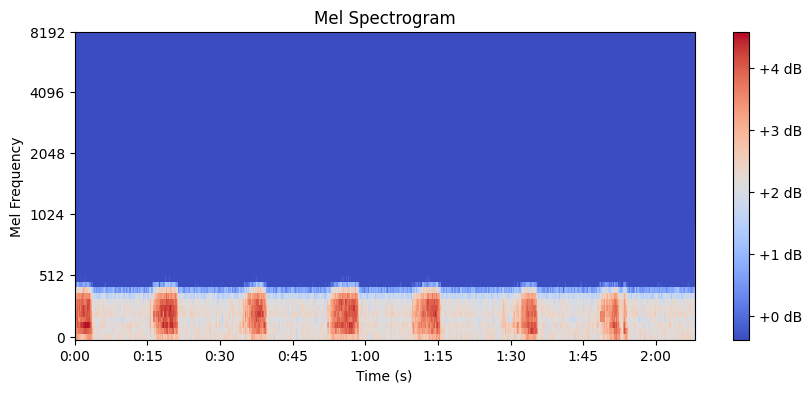

320000
[0.002232   0.00253888 0.00282251 ... 0.00361444 0.00360325 0.00354446]
(64, 2001)
[[ 2.343127    2.4451852   2.4890733  ...  2.4677398   2.432596
   2.3486443 ]
 [ 2.2184937   2.6446671   3.0313044  ...  2.2966805   2.2244174
   2.1969194 ]
 [ 1.8079195   2.4911458   2.8940501  ...  2.5126586   2.266551
   2.236967  ]
 ...
 [-0.38180506 -0.38180506 -0.38180506 ... -0.38180506 -0.38180506
  -0.38180506]
 [-0.38180506 -0.38180506 -0.38180506 ... -0.38180506 -0.38180506
  -0.38180506]
 [-0.38180506 -0.38180506 -0.38180506 ... -0.38180506 -0.38180506
  -0.38180506]]


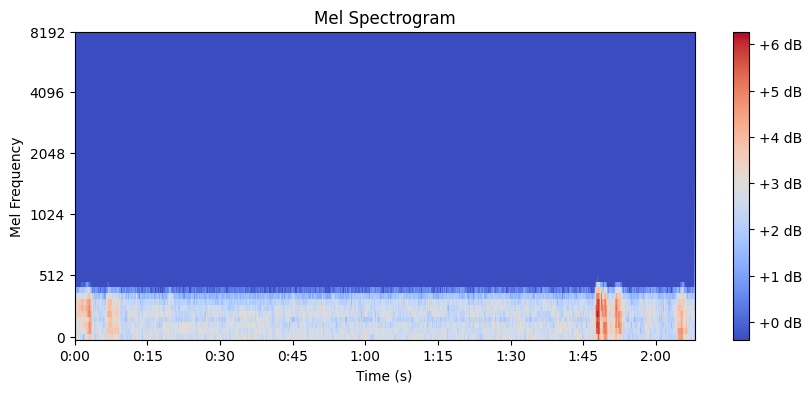

320000
[0.00040379 0.00036495 0.00033299 ... 0.00400993 0.00383013 0.00361824]
(64, 2001)
[[ 2.334225    2.3964086   2.5019615  ...  2.486604    2.5193012
   2.4943626 ]
 [ 2.2829978   2.5520782   2.7258542  ...  2.360127    2.4204402
   2.33717   ]
 [ 2.0223277   2.2878015   2.4936476  ...  2.707029    2.6915293
   2.5031335 ]
 ...
 [ 0.07454576 -0.02862171 -0.41187015 ...  0.4134505   0.7944362
   0.89639217]
 [ 0.06564263 -0.03752655 -0.4167886  ...  0.40437132  0.78535295
   0.88730615]
 [ 0.05771425 -0.04545902 -0.4167886  ...  0.39628294  0.7772608
   0.8792125 ]]


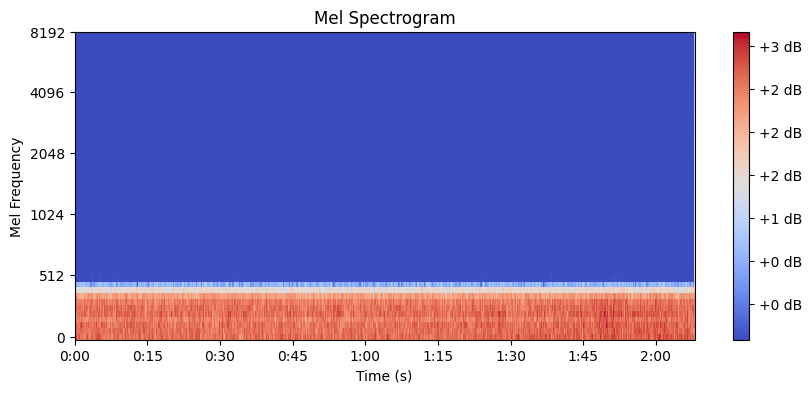

320000
[0.02697389 0.02746411 0.0278124  ... 0.0112851  0.00939979 0.00744324]
(64, 2001)
[[2.7146895  2.8015387  2.776498   ... 2.5575075  2.5719829  2.4820845 ]
 [2.6109264  2.6372128  2.6444407  ... 2.5666552  2.4847305  2.3191128 ]
 [2.6610456  2.6955206  2.7520611  ... 2.5304437  2.45748    2.3698199 ]
 ...
 [1.296166   1.1979568  0.83329767 ... 0.3168418  0.6794851  0.7766148 ]
 [1.2875656  1.1893569  0.8246996  ... 0.30787253 0.6704997  0.76762086]
 [1.279907   1.1816992  0.8170432  ... 0.29986304 0.66247576 0.75958896]]


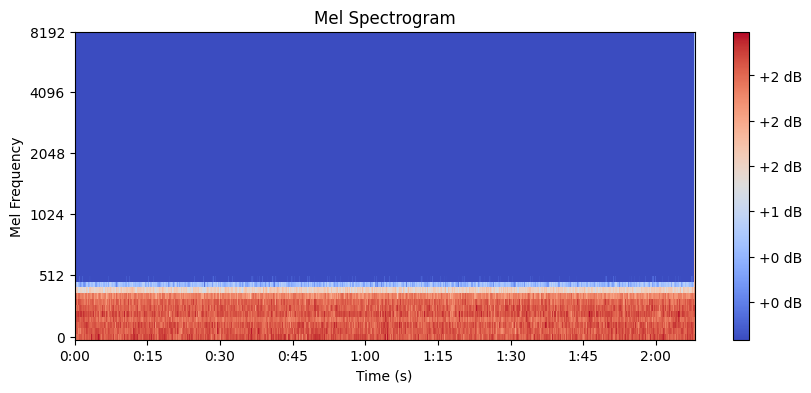

320000
[-0.03619451 -0.04498167 -0.05324028 ... -0.01639498 -0.01666542
 -0.01682116]
(64, 2001)
[[2.7181523  2.7409027  2.7412913  ... 2.43865    2.3327568  2.1144762 ]
 [2.6722248  2.6487427  2.6125588  ... 2.5919178  2.4623764  2.2096598 ]
 [2.7672446  2.786892   2.8852699  ... 2.7461782  2.625961   2.3844752 ]
 ...
 [0.966007   0.8457078  0.39943767 ... 0.1135959  0.5564956  0.6749895 ]
 [0.9549867  0.8346972  0.3884451  ... 0.10307088 0.54597056 0.6644645 ]
 [0.9451478  0.82486784 0.37863344 ... 0.09369817 0.53659785 0.6550922 ]]


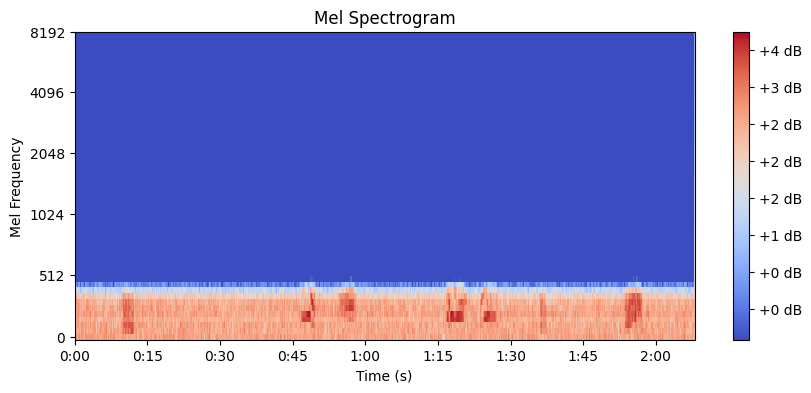

2025-02-05 10:33:57.825775: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
for data in parsed_data.take(5):
    audio = data[0].numpy()
    print(len(audio))
    print(audio)    
    mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr = sampling_rate, n_fft = fft_length, hop_length = sequence_stride, n_mels = num_mel_bins, fmin = 0, fmax = 2048)
    print(mel_spectrogram.shape)
    mel_spec_db = librosa.power_to_db(mel_spectrogram)
    mel_spec_norm = (mel_spec_db - np.mean(mel_spec_db))/(np.std(mel_spec_db))
    print(mel_spec_norm)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_norm, sr=sampling_rate, x_axis="time", y_axis="mel", fmax=8000)
    plt.colorbar(format="%+2.0f dB")  # Colorbar for decibel values
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

In [9]:
num_mel_bins = 64
sampling_rate = 8000
sequence_stride = 160
fft_length = 400
n_samples = 320000

In [7]:
train_audio_data, valid_audio_data, test_audio_data = utils.prepare_data_subset(data_labels, feature = 'audio', train_length= 8000, valid_length = 800, test_length = 800, train_batch_size= 128, valid_test_batch_size= 32)

In [15]:
for data in train_audio_data.take(1):
    audio = data[0].numpy()
    mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr = sampling_rate, n_fft = fft_length, hop_length = sequence_stride, n_mels = num_mel_bins)
    print(mel_spectrogram.shape)

(128, 64, 2001)


2025-02-05 10:21:56.336251: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
normal_audio = 